In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import Global_Functions as gf
import matplotlib.pyplot as plt

In [2]:
import time
timestr = time.strftime("%Y-%m-%d_%H-%M")

In [3]:
OPEN_FOLDER = '../Data/Preped_Data/'

In [4]:
ex_1 = gf.open_CSV_file('experiment_1_short.csv', OPEN_FOLDER)
ex_4 = gf.open_CSV_file('experiment_4_short.csv', OPEN_FOLDER)
ex_9 = gf.open_CSV_file('experiment_9_short.csv', OPEN_FOLDER)
ex_20 = gf.open_CSV_file('experiment_20_short.csv', OPEN_FOLDER)
ex_21 = gf.open_CSV_file('experiment_21_short.csv', OPEN_FOLDER)
ex_22 = gf.open_CSV_file('experiment_22_short.csv', OPEN_FOLDER)
ex_23 = gf.open_CSV_file('experiment_23_short.csv', OPEN_FOLDER)
ex_24 = gf.open_CSV_file('experiment_24_short.csv', OPEN_FOLDER)

In [5]:
image_path = "../Images/"
image_subfolder = "RNN/"
image_folder = image_path + image_subfolder + timestr + "/"

gf.check_folder(image_path)
gf.check_folder(image_path + image_subfolder)
gf.check_folder(image_folder)

Folder already exists.
Folder already exists.
Creation of directory ../Images/RNN/2021-03-11_12-14/ successful.


In [6]:
kit_orange = gf.get_color('orange')
kit_green = gf.get_color('green')
kit_blue = gf.get_color('blue')
kit_cyan = gf.get_color('cyan')
kit_red = gf.get_color('red')
kit_lightgreen = gf.get_color('lightgreen')
kit_grey = gf.get_color('grey')

# Implementing LSTM
We follow the tutorial at https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/ for the implementation

In [7]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy


# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, val, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    
    # transform val
    val = val.reshape(val.shape[0], val.shape[1])
    val_scaled = scaler.transform(val)
    
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, val_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

<ipython-input-7-667b6dfa675b>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [8]:
gap = 50

In [9]:
def prepData(data, gap):
    raw_values = data.values
    diff_values = difference(raw_values, gap)
    supervised = timeseries_to_supervised(diff_values, gap)
    return supervised.values

In [10]:
train = prepData(ex_20['el_power'], gap)
val = prepData(ex_23['el_power'], gap)
test = prepData(ex_22['el_power'], gap)

In [25]:
train.shape

(6908, 51)

In [11]:
scaler, train_scaled, val_scaled, test_scaled = scale(train, val, test)

In [12]:
lstm_model = fit_lstm(train_scaled, 1, 30, 64)

6908/6908 [==============================] - 6s 824us/step - loss: 0.0021


In [13]:
train_reshaped = train_scaled[:, :-1].reshape(len(train_scaled[:, 0]), 1, gap)
train_preds_scaled = lstm_model.predict(train_reshaped, batch_size = 1)

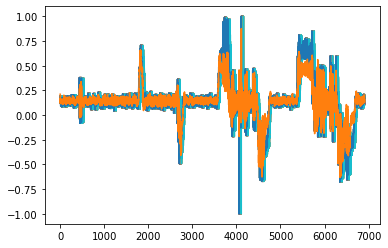

In [14]:
plt.plot(train_scaled)
plt.plot(train_preds_scaled)

In [15]:
predictions_test = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(ex_22['el_power'].values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions_test.append(yhat)   

In [29]:
test_scaled

array([[0.13918246, 0.13918246, 0.13918246, ..., 0.13918246, 0.13918246,
        0.19606308],
       [0.19606308, 0.13918246, 0.13918246, ..., 0.13918246, 0.13918246,
        0.18449243],
       [0.18449243, 0.19606308, 0.13918246, ..., 0.13918246, 0.13918246,
        0.15553265],
       ...,
       [0.1090249 , 0.13631895, 0.11405198, ..., 0.15988028, 0.08892304,
        0.13402445],
       [0.13402445, 0.1090249 , 0.13631895, ..., 0.11505288, 0.15988028,
        0.10387988],
       [0.10387988, 0.13402445, 0.1090249 , ..., 0.13955202, 0.11505288,
        0.17092268]])

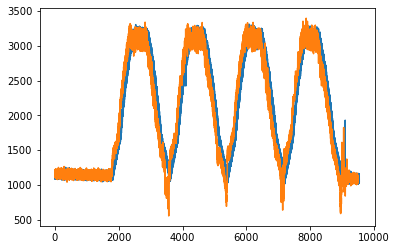

In [16]:
plt.plot(ex_22['el_power'])
plt.plot(predictions_test)

In [17]:
predictions_val = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = val_scaled[i, 0:-1], val_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(ex_23['el_power'].values, yhat, len(val_scaled)+1-i)
    # store forecast
    predictions_val.append(yhat)   

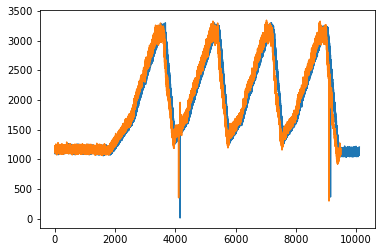

In [18]:
plt.plot(ex_23['el_power'])
plt.plot(predictions_val)

In [19]:
ex_9_prep = prepData(ex_9['el_power'], gap)
ex_9_scaled = scaler.transform(ex_9_prep)

In [20]:
predictions_9 = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = ex_9_scaled[i, 0:-1], ex_9_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(ex_9['el_power'].values, yhat, len(ex_9_scaled)+1-i)
    # store forecast
    predictions_9.append(yhat)   

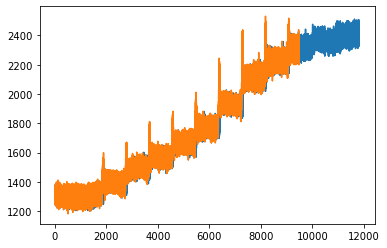

In [21]:
plt.plot(ex_9['el_power'])
plt.plot(predictions_9)